# Accessing SOCCOM's Biogeochemical ARGO Floats
This tutorial highlights how to connect to an anaymous FTP, and automate some preprocessing using Pandas.

In [1]:
from ftplib import FTP

In [2]:
host = 'ftp.mbari.org'
data_in_dir = 'pub/SOCCOM/FloatVizData/QC/'
encoding = 'iso-8859-1'

Make a connection to the FTP as an anonymous user.

In [3]:
ftp_cnx = FTP(host, 'anonymous')

Change the ftp directory to where the files live.

In [4]:
ftp_cnx.cwd(data_in_dir)

'250 Directory successfully changed.'

Before we read any files from the ftp to our local machine, let's get a list of targets.

In [5]:
ftp_cnx.nlst()[:5]

['0037SoOcnQC.TXT',
 '0068RossSeaQC.TXT',
 '0069BermudaQC.TXT',
 '0276NoAtlanticQC.TXT',
 '0412HawaiiQC.TXT']

close the connection to the FTP.

In [10]:
ftp_cnx.close()

In the interest of downloading files programmatically, let's wrap these procedures into a method...

In [135]:
def list_records(host, directory, full_path=False):
    '''
    Similar to Linux directory list (ls).
    Connects to FTP and Returns list of files.
    '''
    with FTP(host, 'anonymous', timeout=5) as ftp_cnx:
        ftp_cnx.cwd(data_in_dir)

        files = []

        try:
            files = ftp_cnx.nlst()
        
        except(ftplib.error_perm, resp):
            if str(resp) == "550 No files found":
                print("No files in this directory")
            else:
                raise
                
    if full_path:
        return [os.path.join('ftp://', host, data_in_dir, f) for f in files]
    else:
        return files

In [137]:
files = list_records(host, data_in_dir, full_path=True)
files[:5]

['ftp://ftp.mbari.org/pub/SOCCOM/FloatVizData/QC/0037SoOcnQC.TXT',
 'ftp://ftp.mbari.org/pub/SOCCOM/FloatVizData/QC/0068RossSeaQC.TXT',
 'ftp://ftp.mbari.org/pub/SOCCOM/FloatVizData/QC/0069BermudaQC.TXT',
 'ftp://ftp.mbari.org/pub/SOCCOM/FloatVizData/QC/0276NoAtlanticQC.TXT',
 'ftp://ftp.mbari.org/pub/SOCCOM/FloatVizData/QC/0412HawaiiQC.TXT']

what does the data look like?

In [22]:
import os
import urllib.request as ur

In [218]:
ftp_url = files[0]

In [219]:
# request file from FTP
req = ur.Request(ftp_url)
file = ur.urlopen(req)

In [221]:
# Read file as string
raw_data = file.read().decode(encoding)

In [227]:
print(raw_data[:644])

//0
//Oxygen,  1.045
//Nitrate, 1, 1, 1,0
//Nitrate, 2, 1, -1, 0
//Nitrate, 3, 1, -.5, 0
//Nitrate, 88, 1, 0.8,0
//Chl,  0.5, 0
//BB, 1, 0
Cruise	Station	Type	mon/day/yr	hh:mm	Lon [°E]	Lat [°N]	Bot. Depth[m]	Depth[m]	QF	Temperature[°C]	QF	Salinity	QF	Density	QF	Oxygen[µM]	QF	OxygenSat[%]	QF	Nitrate[µM]	QF	Chlorophyll[µg/l]	QF	BackScatter[/m/sr]	QF	CDOM[ppb]	QF
0037SoOcn	1	C	12/05/2014	21:51	11.352	-39.254		1798.80	0	2.7423	0	34.7770	0	27.731	0	210.99	0	63.11	0	27.70	0	0.01	0	0.000131	0	2.37	0
0037SoOcn	1	C	12/05/2014	21:51	11.352	-39.254		1699.70	0	2.7685	0	34.7540	0	27.710	0	212.24	0	63.52	0	28.40	0	0.015	0	0.000137	0	2.38	0


What are some thins we realize off the cuff?
1. metadata at the top of the file commented out with two forward slashes ('\\').
2. tab-delimited columns

Some questions to consider:
- Are the metadata fields uniform across files?
- do colum names change?

In [235]:
# on what index does the metadata end?
meta_end = 8

Metadata

In [229]:
data[:meta_end]

[['//0'],
 ['//Oxygen,  1.045'],
 ['//Nitrate, 1, 1, 1,0'],
 ['//Nitrate, 2, 1, -1, 0'],
 ['//Nitrate, 3, 1, -.5, 0'],
 ['//Nitrate, 88, 1, 0.8,0'],
 ['//Chl,  0.5, 0'],
 ['//BB, 1, 0']]

column headers

In [230]:
data[meta_end]

['Cruise',
 'Station',
 'Type',
 'mon/day/yr',
 'hh:mm',
 'Lon [°E]',
 'Lat [°N]',
 'Bot. Depth[m]',
 'Depth[m]',
 'QF',
 'Temperature[°C]',
 'QF',
 'Salinity',
 'QF',
 'Density',
 'QF',
 'Oxygen[µM]',
 'QF',
 'OxygenSat[%]',
 'QF',
 'Nitrate[µM]',
 'QF',
 'Chlorophyll[µg/l]',
 'QF',
 'BackScatter[/m/sr]',
 'QF',
 'CDOM[ppb]',
 'QF']

rows of data

In [231]:
data[meta_end + 1]

['0037SoOcn',
 '1',
 'C',
 '12/05/2014',
 '21:51',
 '11.352',
 '-39.254',
 '',
 '1798.80',
 '0',
 '2.7423',
 '0',
 '34.7770',
 '0',
 '27.731',
 '0',
 '210.99',
 '0',
 '63.11',
 '0',
 '27.70',
 '0',
 '0.01',
 '0',
 '0.000131',
 '0',
 '2.37',
 '0']

In [236]:
print("This file contains {} rows.".format(len(data[meta_end + 1:])))

This file contains 38837 rows.


We can read the data into a tabular data structure, such as a Pandas Dataframe or a MySQL database.

In [257]:
df = pd.DataFrame(data= data[meta_end + 1:], 
                  columns= data[meta_end])

In [258]:
df.head()

,Cruise,Station,Type,mon/day/yr,hh:mm,Lon [°E],Lat [°N],Bot. Depth[m],Depth[m],QF,...,OxygenSat[%],QF,Nitrate[µM],QF,Chlorophyll[µg/l],QF,BackScatter[/m/sr],QF,CDOM[ppb],QF
0,0037SoOcn,1,C,12/05/2014,21:51,11.352,-39.254,,1798.80,0,...,63.11,0,27.70,0,0.01,0,0.000131,0,2.37,0
1,0037SoOcn,1,C,12/05/2014,21:51,11.352,-39.254,,1699.70,0,...,63.52,0,28.40,0,0.015,0,0.000137,0,2.38,0
2,0037SoOcn,1,C,12/05/2014,21:51,11.352,-39.254,,1598.90,0,...,61.70,0,29.50,0,0.015,0,0.000133,0,2.40,0
3,0037SoOcn,1,C,12/05/2014,21:51,11.352,-39.254,,1499.90,0,...,59.48,0,30.60,0,0.015,0,0.000138,0,2.35,0
4,0037SoOcn,1,C,12/05/2014,21:51,11.352,-39.254,,1399.60,0,...,57.76,0,31.70,0,0.01,0,0.000135,0,2.35,0


To do this easily for other files in the FTP, we must ignore rows containing metadata (where line starts with '//')

In [201]:
import sys

In [206]:
def find_data_start(ftp_url):

    try:
        # request from the FTP
        req = ur.Request(ftp_url)
        f = urlopen_retry(req)
    except:
        print('Unexpected error: {}'
              '\nCheck ftp directory is correct.'.format(sys.exc_info()[0]))
        raise
    
    # read the file into disk as a string.
    raw_data = f.read().decode(encoding).split('\n')
    
    # This is where we look for the metadata to end.
    for index, row in enumerate(raw_data):
        if row[:2] != '//' and row:
            return index

In [237]:
find_data_start(ftp_url)

8

How we know where the headers begin.

In [238]:
data[find_data_start(ftp_url)]

['Cruise',
 'Station',
 'Type',
 'mon/day/yr',
 'hh:mm',
 'Lon [°E]',
 'Lat [°N]',
 'Bot. Depth[m]',
 'Depth[m]',
 'QF',
 'Temperature[°C]',
 'QF',
 'Salinity',
 'QF',
 'Density',
 'QF',
 'Oxygen[µM]',
 'QF',
 'OxygenSat[%]',
 'QF',
 'Nitrate[µM]',
 'QF',
 'Chlorophyll[µg/l]',
 'QF',
 'BackScatter[/m/sr]',
 'QF',
 'CDOM[ppb]',
 'QF']

Let's preview the data in Pandas

In [1]:
import time

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 

In [149]:
ftp_url

'ftp://ftp.mbari.org/pub/SOCCOM/FloatVizData/QC/6881StnPQC.TXT'

In [191]:
def urlopen_retry(req):
    '''urlopen can fail because of network issues, let's retry the method 3 times.
    Let's also let 5 seconds go by.
    '''
    attempts = 0

    while attempts < 3:
       
        class MyException(Exception):
            pass

        try:
            file = ur.urlopen(req, timeout= 180)
            break
        except ur.URLError as e:
            attempts += 1
            time.sleep(5)
            if isinstance(e.reason, socket.timeout):
                raise MyException("There was an error: %r" % e)
            else:
                # reraise the original error
                raise
        except socket.timeout as e:
            attempts += 1
            time.sleep(5)
            raise MyException("There was an error: %r" % e)
       
    return file

In [192]:
def preprocess(df):
    '''Removes unamed, and QF columns.
    Fills columns with null vals when the dataframe doesn't have the column.
    '''
    df = df[[col for col in df.columns 
             if 'QF' not in col 
             and 'Unnamed' not in col]]
    
    df.columns = [remap_cols.get(col, col) for col in df.columns]
    
    # fill null columns
    for col in missing_cols:
        if col not in df:
            df[col] = np.nan
    
    return df

In [188]:
def ftp_to_df(ftp_url, nrows=None):
    '''
    Checks where data starts in ftp file.
    requests ftp file.
    normalizes the columns.
    '''
    # find where to skip metadata.
    skip_index = find_data_start(ftp_url)
    
    # get the FTP file
    req = ur.Request(ftp_url)
    file = urlopen_retry(req)
    
    # read the file as a Pandas dataframe.
    df = pd.read_csv(file, sep= '\t', nrows= nrows,
                     skiprows= skip_index, 
                     encoding= encoding,
                     error_bad_lines= False,
                     warn_bad_lines= False)
    
    # normalize samples
    df = preprocess(df)
    return df

In [190]:
df = ftp_to_df(ftp_url)
df.head()

,Cruise,Station,Type,mon/day/yr,hh:mm,Lon [°E],Lat [°N],Bot. Depth[m],Depth[m],Temperature[°C],Salinity,Density,Oxygen[µM],OxygenSat[%],Nitrate[µM],pHinsitu[Total],pH25C[Total],Chlorophyll[µg/l],CDOM[ppb],BackScatter[/m/sr]
0,6881StnP,1,C,02/13/2013,15:02,214.901,50.075,NaN,998.61,2.8516,34.3867,27.368,16.69,4.99,46.14,NaN,NaN,NaN,NaN,NaN
1,6881StnP,1,C,02/13/2013,15:02,214.901,50.075,NaN,951.33,2.9087,34.3733,27.352,17.47,5.23,46.25,NaN,NaN,NaN,NaN,NaN
2,6881StnP,1,C,02/13/2013,15:02,214.901,50.075,NaN,901.56,2.9634,34.3609,27.336,16.91,5.07,46.23,NaN,NaN,NaN,NaN,NaN
3,6881StnP,1,C,02/13/2013,15:02,214.901,50.075,NaN,849.01,3.0817,34.3343,27.302,16.69,5.02,45.95,NaN,NaN,NaN,NaN,NaN
4,6881StnP,1,C,02/13/2013,15:02,214.901,50.075,NaN,801.64,3.1733,34.3139,27.276,16.58,5.00,46.04,NaN,NaN,NaN,NaN,NaN


In [192]:
df.dtypes

Cruise                 object
Station                 int64
Type                   object
mon/day/yr             object
hh:mm                  object
Lon [°E]              float64
Lat [°N]              float64
Bot. Depth[m]         float64
Depth[m]              float64
QF                    float64
Temperature[°C]       float64
QF.1                  float64
Salinity              float64
QF.2                  float64
Density               float64
QF.3                  float64
Oxygen[µM]            float64
QF.4                  float64
OxygenSat[%]          float64
QF.5                  float64
Nitrate[µM]           float64
QF.6                  float64
Chlorophyll[µg/l]     float64
QF.7                  float64
BackScatter[/m/sr]    float64
QF.8                  float64
CDOM[ppb]             float64
QF.9                  float64
dtype: object

Are all columns the same accross files?

In [106]:
cols = dict()

for file in files[:-5]:
    ftp_url = os.path.join('ftp://', host, data_in_dir, file)
    df = ftp_to_df(ftp_url, nrows=5)
        
    time.sleep(1)    

In [112]:
cols

{'BackScatter[/m/sr]': 65,
 'Bot. Depth [m]': 6,
 'Bot. Depth[m]': 98,
 'CDOM[ppb]': 14,
 'Chlorophyll[µg/l]': 62,
 'Chlorophyll[Âµg/l]': 3,
 'Cruise': 104,
 'Density': 104,
 'Depth[m]': 104,
 'Lat [°N]': 101,
 'Lat [Â°N]': 3,
 'Log of changes done on 10/30/2013:': 1,
 'Lon [°E]': 101,
 'Lon [Â°E]': 3,
 'Nitrate[µM]': 101,
 'Nitrate[ÂµM]': 3,
 'OxygenSat[%]': 104,
 'Oxygen[µM]': 101,
 'Oxygen[ÂµM]': 3,
 'QF': 104,
 'QF.1': 104,
 'QF.10': 44,
 'QF.11': 12,
 'QF.2': 104,
 'QF.3': 104,
 'QF.4': 104,
 'QF.5': 104,
 'QF.6': 104,
 'QF.7': 76,
 'QF.8': 76,
 'QF.9': 46,
 'Salinity': 104,
 'Station': 104,
 'Temperature[°C]': 101,
 'Temperature[Â°C]': 3,
 'Type': 104,
 'hh:mm': 104,
 'mon/day/yr': 104,
 'pH25C[Total]': 55,
 'pHinsitu[Total]': 55}

We can fix some of these discrepencies by renaming columns.<br>
We can also create placeholders for missing columns.

In [59]:
remap_cols = {'Temperature[Â°C]': 'Temperature[°C]',
              'Oxygen[ÂµM]': 'Oxygen[µM]',
              'Nitrate[ÂµM]': 'Nitrate[µM]',
              'Lon [Â°E]': 'Lon [°E]',
              'Lat [Â°N]': 'Lat [°N]',
              'Chlorophyll[Âµg/l]' : 'Chlorophyll[µg/l]',
              'Bot. Depth [m]': 'Bot. Depth[m]'}

missing_cols = ['pHinsitu[Total]',
                'pH25C[Total]',
                'Chlorophyll[µg/l]',
                'CDOM[ppb]',
                'BackScatter[/m/sr]']

In [157]:
targets = list_records(host, data_in_dir, full_path=True)[:-5]

Using the list of files from `list_records()`, we can get hit the FTP and send it's contents into individual Pandas dataframes, which we will concatenate as `combined_df`

In [154]:
from multiprocessing import Pool, freeze_support

In [193]:
freeze_support()
with Pool(3) as pool:
    df_list = pool.map(ftp_to_df, targets)
    combined_df = pd.concat(df_list, ignore_index=True) 

In [194]:
combined_df.describe().T

,count,mean,std,min,25%,50%,75%,max
BackScatter[/m/sr],676846.0,0.002738,0.168231,-0.000635,0.000108,0.000123,0.000147,10.94342
Bot. Depth[m],0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CDOM[ppb],362270.0,79.402412,3663.622839,0.130000,1.670000,2.050000,2.830000,182865.79000
Chlorophyll[µg/l],676846.0,8.444038,547.552034,-2.410000,0.005091,0.020000,0.060000,36908.67000
Density,1156420.0,26.532823,1.184378,17.858000,26.008000,26.851000,27.337000,51.87800
Depth[m],1156420.0,378.863805,340.335340,1.980000,101.860000,280.970000,592.000000,2003.80000
Lat [°N],1091024.0,2.784207,43.158038,-70.517000,-46.524000,22.389000,34.619000,83.10300
Lon [°E],1091024.0,127.539108,147.150272,-170.162000,11.134000,198.290000,221.129000,359.96500
Nitrate[µM],740960.0,19.728505,15.547847,-228.010000,5.910000,19.320000,33.210000,260.51000
OxygenSat[%],1155385.0,77.953511,126.987055,-10.560000,55.060000,77.280000,94.660000,2078.61000


Let's save it for later.

In [195]:
combined_df.to_csv('data_in/buoys.tsv.gzip', 
                   index= False, sep= '\t', 
                   compression= 'gzip', 
                   encoding= 'utf-8')

If you're new to Pandas we created a tab-delimited file, that is gzip compressed, and utf-8 encoded.

We can easily read it back into a Pandas Dataframe with `to_csv()`'s counterpart `read_csv()`.

In [3]:
df = pd.read_csv('data_in/buoys.tsv.gzip', sep='\t', compression='gzip')

In [4]:
len(df)

1163996

We can perform SQL-like aggregations with a few files of code.

In [213]:
df['Cruise'].value_counts().head()

0412Hawaii        107289
0276NoAtlantic     76640
0037SoOcn          38836
0508SoOcn          27467
7622Hawaii         21894
Name: Cruise, dtype: int64

Filtering the dataframe is very simple...

In [212]:
df[df['Cruise'] == '0412Hawaii'].head()

,BackScatter[/m/sr],Bot. Depth[m],CDOM[ppb],Chlorophyll[µg/l],Cruise,Density,Depth[m],Lat [°N],Lon [°E],Nitrate[µM],OxygenSat[%],Oxygen[µM],Salinity,Station,Temperature[°C],Type,hh:mm,mon/day/yr,pH25C[Total],pHinsitu[Total]
140570,0.000106,NaN,2.96,0.04,0412Hawaii,27.639,1999.9,22.748,-157.99,NaN,31.21,105.8,34.608,1,2.2303,C,19:36,11/3/2014,7.4295,7.6608
140571,0.000106,NaN,2.97,0.04,0412Hawaii,27.633,1949.4,22.748,-157.99,NaN,27.02,91.5,34.605,1,2.2772,C,19:36,11/3/2014,7.4278,7.6601
140572,0.000106,NaN,2.96,0.04,0412Hawaii,27.624,1898.7,22.748,-157.99,NaN,26.16,88.5,34.598,1,2.3115,C,19:36,11/3/2014,7.4201,7.6530
140573,0.000103,NaN,3.00,0.05,0412Hawaii,27.611,1849.9,22.748,-157.99,NaN,24.98,84.3,34.592,1,2.4197,C,19:36,11/3/2014,7.4098,7.6419
140574,0.000106,NaN,3.01,0.04,0412Hawaii,27.604,1799.9,22.748,-157.99,NaN,24.18,81.5,34.589,1,2.4701,C,19:36,11/3/2014,7.4070,7.6399


Pandas extends matplotlib's plotting capacities nicely.

In [84]:
import seaborn as sns
%matplotlib inline

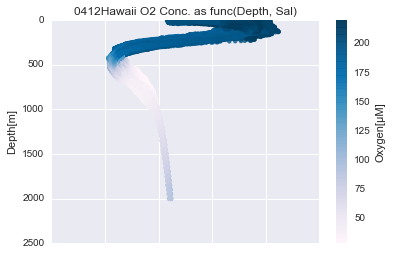

In [105]:
df[df['Cruise'] == '0412Hawaii'].plot(
    x= 'Salinity', y= 'Depth[m]', c= 'Oxygen[µM]',
    kind= 'scatter', colormap='PuBu',
    linewidth=0, alpha =.8, ylim=0,
    title= '{} O2 Conc. as func(Depth, Sal)'.format('0412Hawaii')
).invert_yaxis()

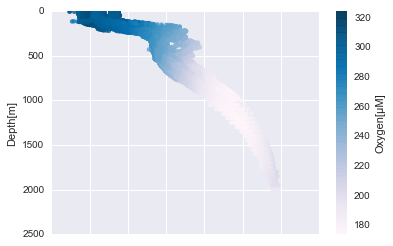

In [104]:
df[df['Cruise'] == '0508SoOcn'].plot(
    x= 'Salinity', y= 'Depth[m]', c= 'Oxygen[µM]',
    kind= 'scatter', colormap='PuBu',
    linewidth=0, alpha =.8, ylim=0
).invert_yaxis()